In [1]:
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time

In [2]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

from tqdm import tqdm

In [3]:
#roc-curve calculations
from sklearn.metrics import roc_auc_score, roc_curve

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [4]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}
part_dict = {
    -211 : 1,
    13 : 0
}

Input:
1. \# hits per layer
2. total energy per layer

56 total

* 0-27: pixels per layer
* 28: primary momentum
* 29: layers traversed
* 30: label (don't include in sample)

Total length: 31
Sample length: 30

In [5]:
def inverse(x,a,b,c):
    return a  / (x + b) + c
def calculate_num_pixels_z_dependence(energy_dep, z_hit):
    efficiency = inverse(770 - z_hit,494.98,9.9733,-0.16796)
    return 10 * energy_dep * (1000 * 1000) * efficiency

Dataset
1. travel time for each photon

Need to only use daughters of primary

In [6]:
# layer_map,super_layer_map = create_layer_map()
n_bins = 20

theta_min = 0.1745
theta_max = 2.966500

theta_range = theta_max - theta_min

theta_bins = np.linspace(theta_min,theta_max,n_bins)
theta_bins_deg = theta_bins * 180 / 3.1415926535
def r_func(x,y,z):
    return np.sqrt(x**2 + y**2 + z**2)

In [7]:
# path = f"cwork/rck32/eic/work_eic/root_files/June_17/variation_sensor/mu_variation_10kevents_file_0.edm4hep.root:events"
# events = up.open(path)


# Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
# MC_time_branch = events["MCParticles.time"].array(library='np')
# time_branch = events["HcalBarrelHits.time"].array(library='np')
# daughters_begin_branch = events["MCParticles.daughters_begin"].array(library='np')
# daughters_end_branch = events["MCParticles.daughters_end"].array(library='np')
# skipped_daughter = 0

In [8]:
curr_bin = 0
time_diff = []
emission_time_list = []
x_dis = []
y_dis = []
z_dis = []
print(f"Starting file #{curr_bin}")
uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_24/variation_pos/mu/varied_theta_same_pos_{curr_bin}.edm4hep.root:events"
with up.open(uproot_path) as events:

    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')

    time_branch = events["HcalBarrelHits.time"].array(library='np')   

    MC_time_branch = events["MCParticles.time"].array(library='np')
    MC_vertex_x = events["MCParticles.vertex.x"].array(library='np')
    MC_vertex_y = events["MCParticles.vertex.y"].array(library='np')
    MC_vertex_z = events["MCParticles.vertex.z"].array(library='np')
    
    daughters_begin_branch = events["MCParticles.daughters_begin"].array(library='np')
    daughters_end_branch = events["MCParticles.daughters_end"].array(library='np')
    curr_theta = theta_bins[curr_bin]

    break_val = 100
    for event_idx in range(len(time_branch)):
        num_photons = 0
        if(not (event_idx % (break_val // 100))):
            clear_output(wait = True)
            print(f"{event_idx // (break_val // 100)}% done")
        if(event_idx > break_val):
            break
        for hit in range(len(time_branch[event_idx])):
            #check if hit is from optph
            hit_idx = Hits_MC_idx_branch[event_idx][hit]
            if(PDG_branch[event_idx][hit_idx] != -22):
                continue
                if((hit_idx < daughters_begin_branch[event][0]) or (hit_idx > daughters_end_branch[event][0])):
                    skipped_daughter += 1
                    continue
            x_dis.append(MC_vertex_x[event_idx][hit])
            y_dis.append(MC_vertex_y[event_idx][hit])
            z_dis.append(MC_vertex_z[event_idx][hit])
            hit_time = time_branch[event_idx][hit]
            emission_time = MC_time_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] 
            time_diff.append(hit_time - emission_time)
            emission_time_list.append(emission_time)

101% done


In [9]:
x_dis_cut = []
y_dis_cut = []
z_dis_cut = []

In [10]:
for i in range(len(x_dis)):
    if(x_dis[i] > 1800 or x_dis[i] < 1768):
        continue
    if(y_dis[i] > 10 or y_dis[i] < -10):
        continue
    if(z_dis[i] > 10 or z_dis[i] < -10):
        continue
    x_dis_cut.append(x_dis)
    y_dis_cut.append(y_dis)
    z_dis_cut.append(z_dis)

In [ ]:
fig, axs = plot.subplots(2,2, figsize = (12,12))
axs[0,0].set_xlabel("x pos of optph vertex from origin")
axs[0,0].hist(x_dis_cut,bins=10);
axs[0,1].set_xlabel("y pos of optph vertex from origin")
axs[0,1].hist(y_dis_cut,bins=10);
axs[1,0].set_xlabel("z pos of optph vertex from origin")
axs[1,0].hist(z_dis_cut,bins=10);
axs[1,1].set_xlabel("time of emission")
axs[1,1].hist(emission_time_list,bins=100);

In [33]:
for i in range(10,11):
    if(i == 10):
        mu_data = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        pi_data = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
    else:
        add_mu = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        mu_data = torch.cat((mu_data, add_mu),0)
        add_pi = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
        pi_data = torch.cat((pi_data, add_pi),0)
for i in range(14,15):
    if(i == 14):
        test_mu_data = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        test_pi_data = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
    else:
        test_add_mu = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        test_mu_data = torch.cat((test_mu_data, test_add_mu),0)
        test_add_pi = create_data_depth_z_dependence(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
        test_pi_data = torch.cat((test_pi_data, test_add_pi),0)

on event #9000 for file #14 for pion


In [34]:
dataset = torch.cat((mu_data,pi_data),)
indexes = torch.randperm(dataset.shape[0])
dataset_shuffled = dataset[indexes]

test_dataset = torch.cat((test_mu_data,test_pi_data),)
test_indexes = torch.randperm(test_dataset.shape[0])
test_dataset_shuffled = test_dataset[test_indexes]

In [35]:
classifier = Classifier(num_layers = 10, input_size=dataset_shuffled.shape[1] - 1, hidden_dim = 600).to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs_classifier = 15

In [36]:
loss_hist = train(classifier, dataset_shuffled,optimizer, num_epochs = 5)

Training epoch #4


100%|██████████| 200/200 [00:01<00:00, 102.99it/s]

Finished Training


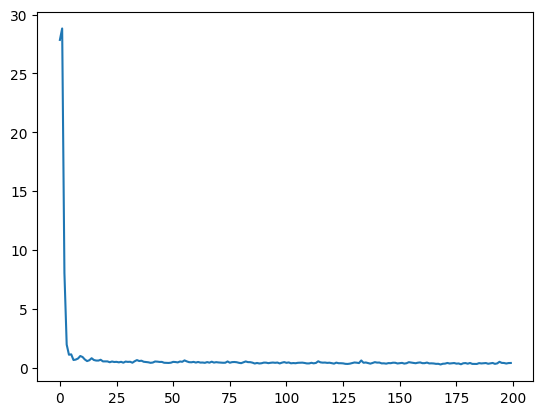

In [37]:
plot.plot(loss_hist)

In [38]:
test_Y,probs_Y = test(classifier, test_dataset_shuffled,return_outputs = True)

100%|██████████| 2000/2000 [00:04<00:00, 480.02it/s]


Accuracy: 84.58


AUC = 0.9253


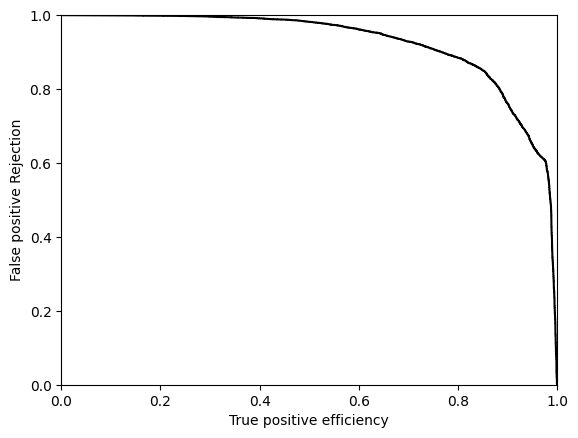

In [49]:
plot_roc_curve(test_Y,probs_Y)

In [48]:
def plot_roc_curve(test_Y, probs_Y):
    verbose = True
    # Get ROC curve
    pfn_fp, pfn_tp, threshs = roc_curve(test_Y, probs_Y[:,1].detach().numpy())

    auc = roc_auc_score(np.squeeze(test_Y), probs_Y[:,1].detach().numpy())
    print(f'AUC = {auc:.4f}')
    f = plot.figure()

    plot.plot(pfn_tp, 1-pfn_fp, '-', color='black')

    # axes labels
    plot.xlabel('True positive efficiency')
    plot.ylabel('False positive Rejection')

    # axes limits
    plot.xlim(0, 1)
    plot.ylim(0, 1)

    f.show()
    f.savefig("./roc_curve.jpeg")

# Cut classification

In [40]:
num_bins = 20
energy_bin_edges = np.linspace(0,10,num_bins + 1)
# assuming 'tensor' is your input tensor
binned_tensor = [torch.ones((1,33), dtype=dataset_shuffled.dtype) * -99 for i in range(num_bins)]

In [41]:
energy_bin_edges

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [42]:
for event in range(dataset_shuffled.shape[0]):
    bin_num = findBin(dataset_shuffled[event,28],energy_bin_edges)
    if(binned_tensor[bin_num][0,32] == -99):
        binned_tensor[bin_num][0] = dataset_shuffled[event]
    else:
        binned_tensor[bin_num] = torch.cat((binned_tensor[bin_num],dataset_shuffled[event].unsqueeze(0)))

In [43]:
pi_energy_binned = []
mu_energy_binned = []
for i in range(len(binned_tensor)):
    pi_bin_mask = binned_tensor[i][:,32] == part_dict[-211]
    pi_energy_binned.append(binned_tensor[i][pi_bin_mask])
    mu_bin_mask = binned_tensor[i][:,32] == part_dict[13]
    mu_energy_binned.append(binned_tensor[i][mu_bin_mask])

In [44]:
pi_energy_binned[0].shape

torch.Size([418, 33])

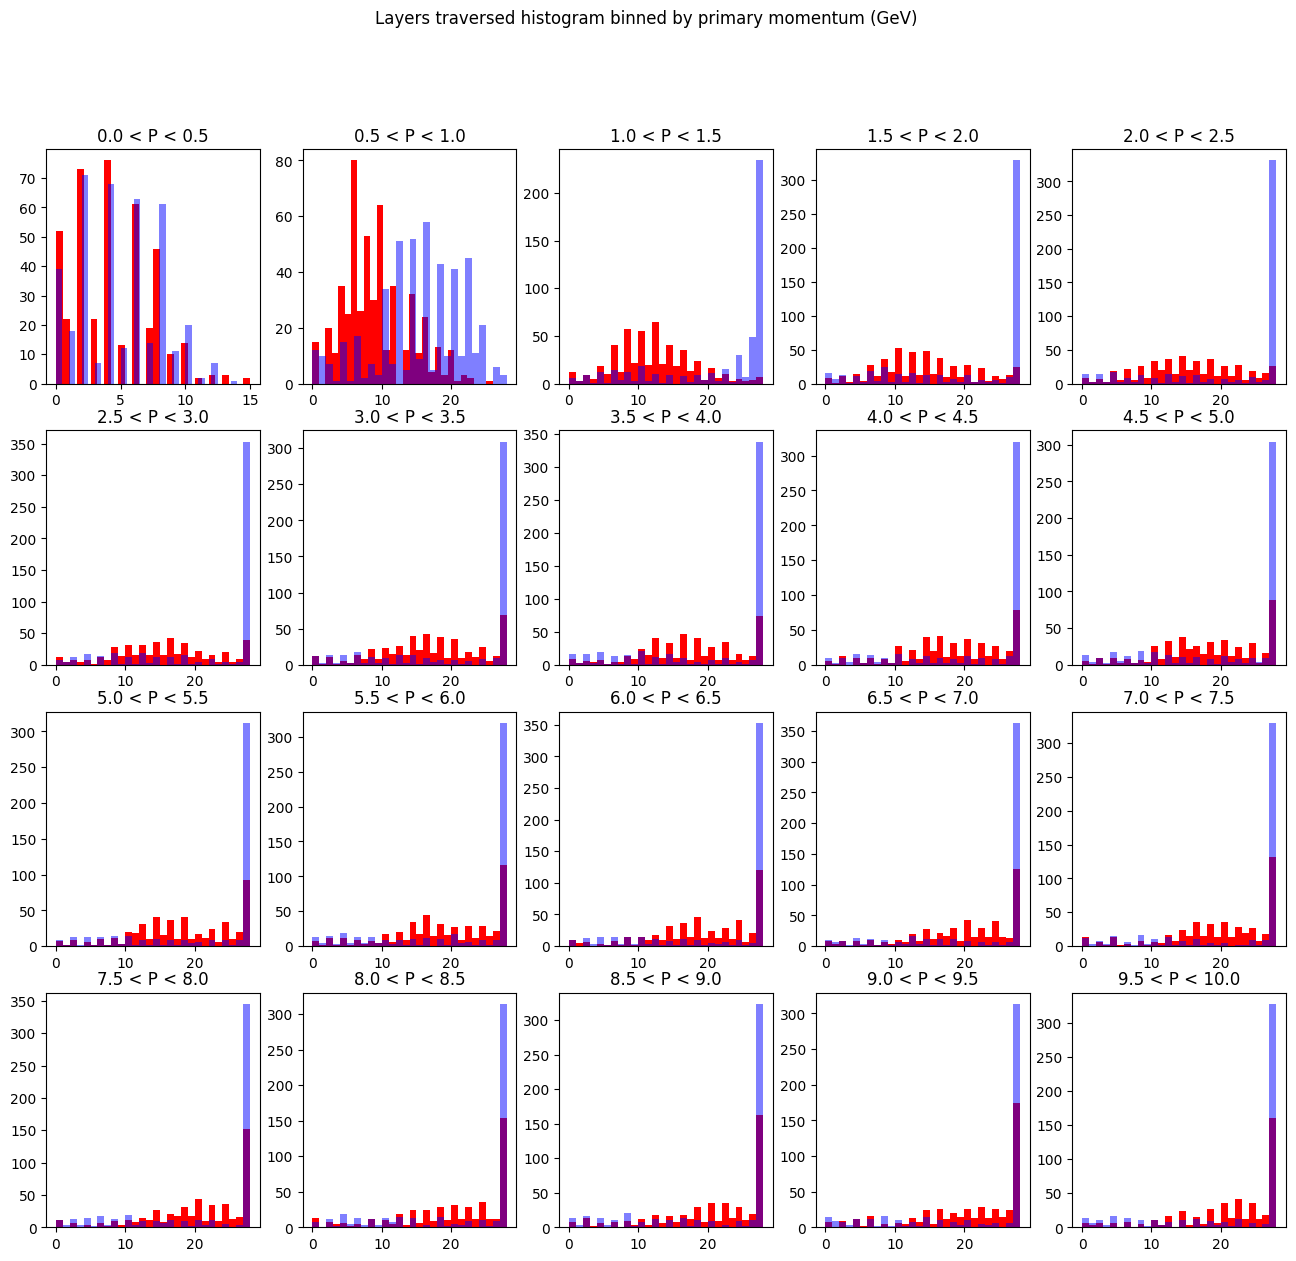

In [45]:
fig, axs = plot.subplots(4,5,figsize = (16,14))
fig.suptitle("Layers traversed histogram binned by primary momentum (GeV)")
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].set_title(f"{energy_bin_edges[i * 5 + j]} < P < {energy_bin_edges[i * 5 + j + 1]}")
        axs[i,j].hist(pi_energy_binned[i * 5 + j][:,31],bins = 28, color = 'r')
        axs[i,j].hist(mu_energy_binned[i * 5 + j][:,31],bins = 28,alpha = 0.5, color = 'b')

In [46]:
mu_correct = np.empty((num_bins,28))
pi_correct = np.empty((num_bins,28))

for i in range(num_bins):
    for j in range(28):
        mu_correct_mask = mu_energy_binned[i][:,31] > j
        mu_correct_set = mu_energy_binned[i][mu_correct_mask]
        mu_correct[i][j]  = mu_correct_set.shape[0] / mu_energy_binned[i].shape[0]
        
        pi_correct_mask = pi_energy_binned[i][:,31] <= j
        pi_correct_set = pi_energy_binned[i][pi_correct_mask]
        pi_correct[i][j]  = pi_correct_set.shape[0] / pi_energy_binned[i].shape[0]

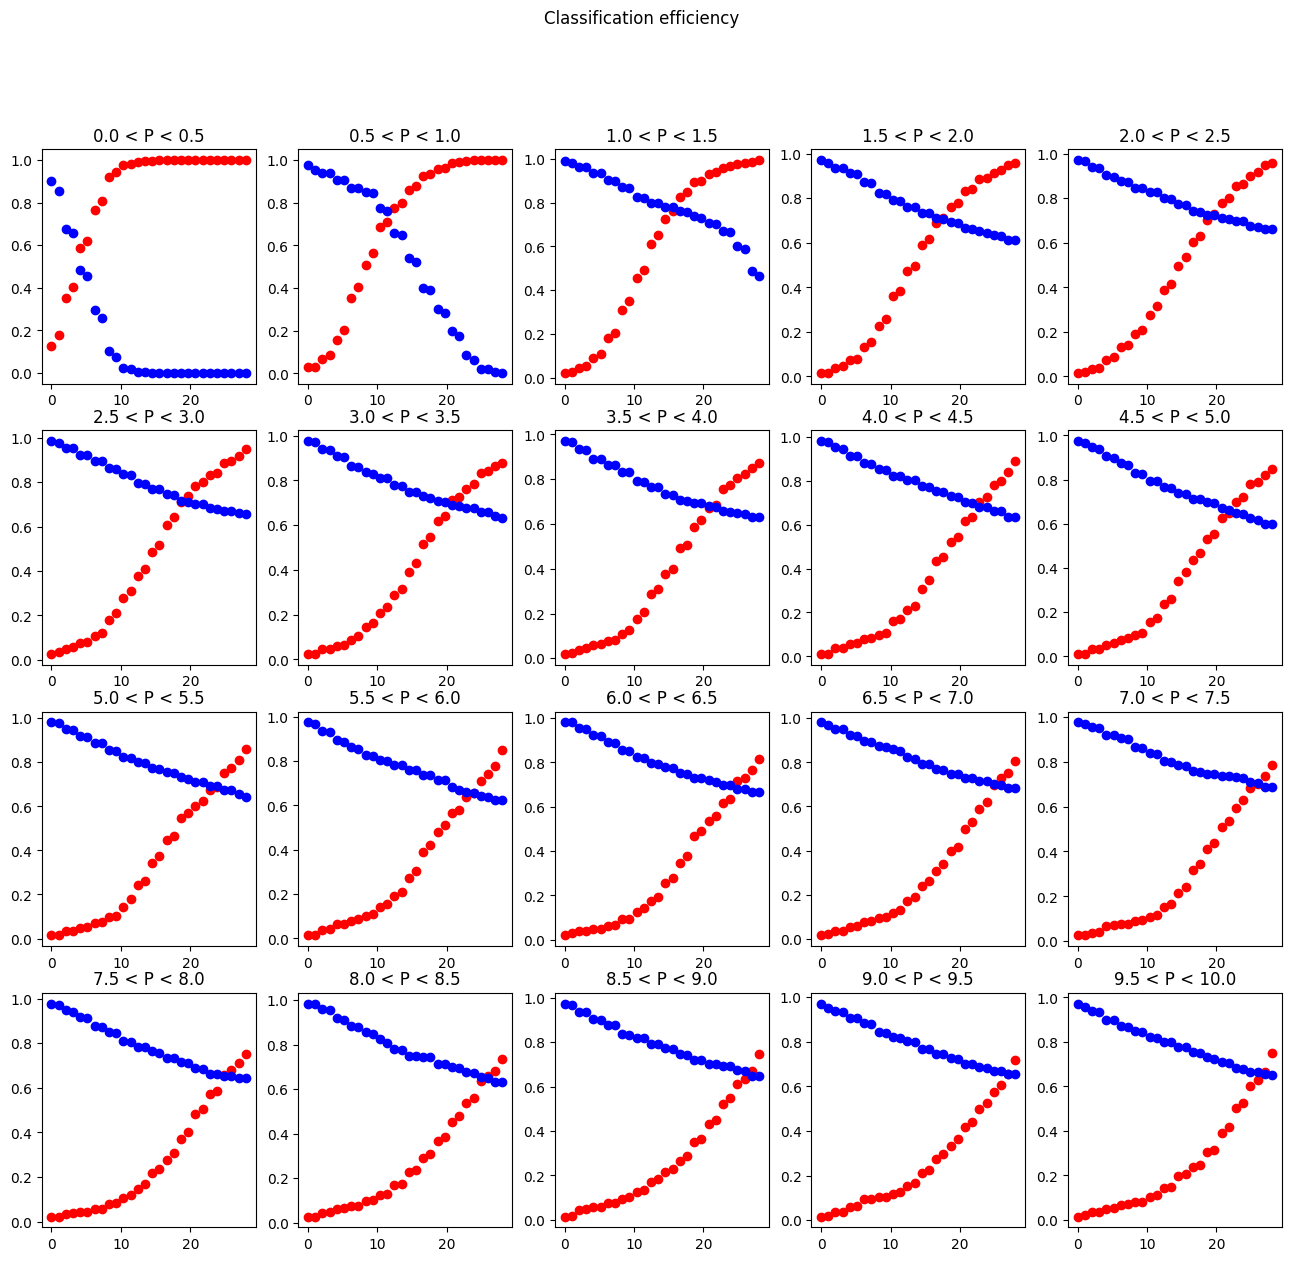

In [47]:
fig, axs = plot.subplots(4,5,figsize = (16,14))
fig.suptitle("Classification efficiency")
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].set_title(f"{energy_bin_edges[i * 5 + j]} < P < {energy_bin_edges[i * 5 + j + 1]}")
        axs[i,j].scatter(np.linspace(0,28,28),pi_correct[i * 5 + j], color = 'r')
        axs[i,j].scatter(np.linspace(0,28,28),mu_correct[i * 5 + j], color = 'b')